### Librairies

In [2]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns 
import missingno as msno
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, 
    AdaBoostRegressor, 
    GradientBoostingRegressor, 
    ExtraTreesRegressor
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

In [3]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

### Fonctions

In [4]:
def plot_histbox(df, column, figsize=(12,5), **kwargs) -> None:
    '''
    Affiche un histogramme et un boxplot pour la colonne du dataframe.
    '''
    fig, ax = plt.subplots(1,2, figsize=figsize)
    fig.suptitle(f"Distribution pour '{column}'")

    sns.boxplot(df[column], ax=ax[0], width=0.4, **kwargs)
    ax[0].set_xlabel("")
    ax[0].set_ylabel("")
    sns.histplot(df[column], ax=ax[1], **kwargs)
    ax[1].set_xlabel("")
    ax[1].set_ylabel("")

    ax[0].set_title("Boxplot")
    ax[1].set_title("Histogram")

    plt.tight_layout()
    plt.show();

In [5]:
def limite_haute(colonne, a=1.5) -> float:
    '''
    Permet de calculer la limite haute pour les outliers en utilisant l'equart interquartile
    '''
    q1, q3 = np.quantile(colonne, [0.25, 0.75])

    iqr = q3 - q1
  
    limite_haute = q3 + a * iqr
    
    return limite_haute

## Préparation des données

### Importation des données

In [6]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)

In [7]:
FILE_PATH = r'data\2016_Building_Energy_Benchmarking.csv'

In [8]:
data = pd.read_csv(FILE_PATH)

In [9]:
data.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.0,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.0,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.0,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

Dictionnaire des données : https://data.seattle.gov/Built-Environment/2016-Building-Energy-Benchmarking/2bpz-gwpy/about_data

In [11]:
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

### Nettoyage des colonnes inutiles

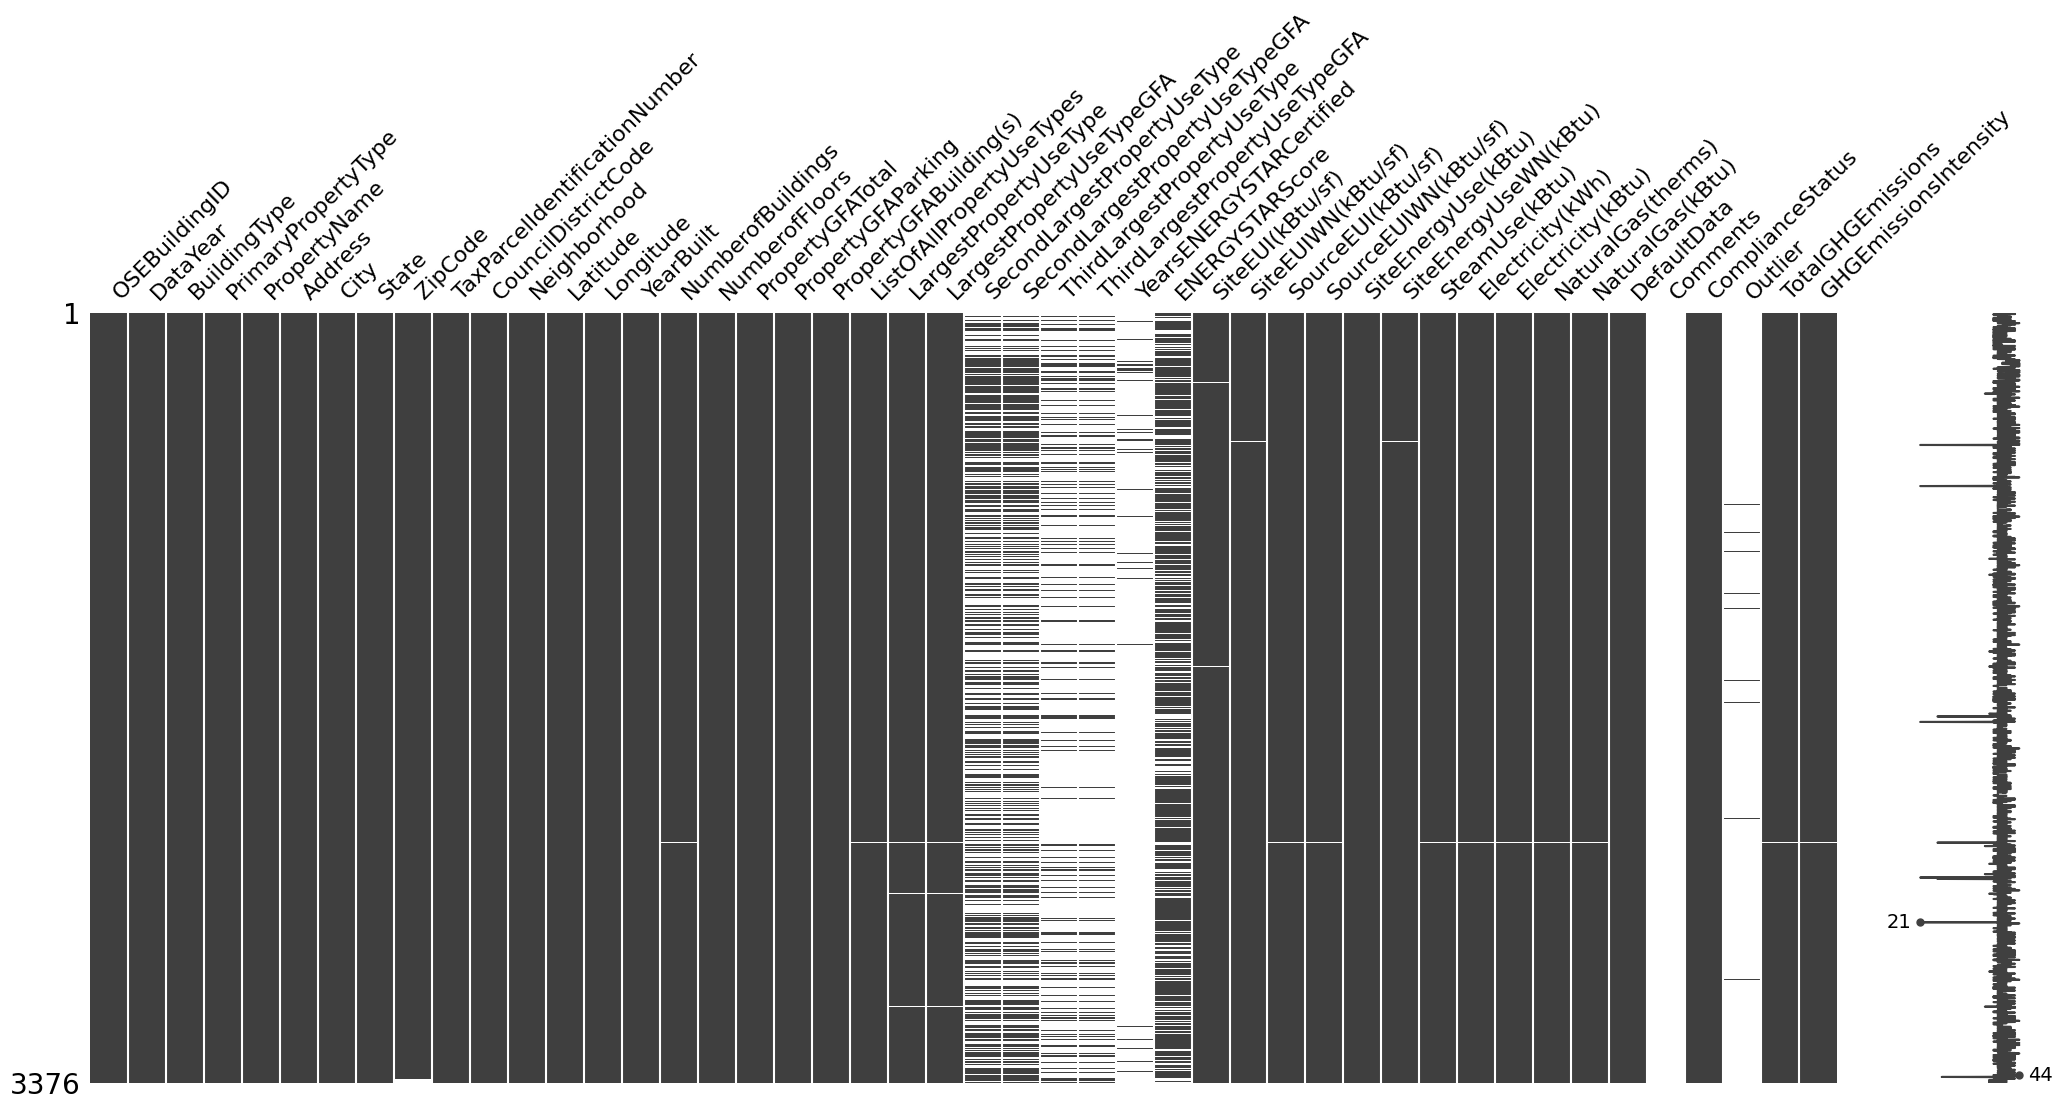

In [12]:
msno.matrix(data);

In [13]:
data.isnull().sum().nlargest(10).sort_values(ascending=False)

Comments                           3376
Outlier                            3344
YearsENERGYSTARCertified           3257
ThirdLargestPropertyUseType        2780
ThirdLargestPropertyUseTypeGFA     2780
SecondLargestPropertyUseType       1697
SecondLargestPropertyUseTypeGFA    1697
ENERGYSTARScore                     843
LargestPropertyUseType               20
LargestPropertyUseTypeGFA            20
dtype: int64

In [14]:
data['DefaultData'].value_counts()

DefaultData
False    3263
True      113
Name: count, dtype: int64

In [15]:
list_useless = ['OSEBuildingID',
                'City',
                'State',
                'DataYear',
                'PropertyName',
                'Comments',
                'Outlier',
                'YearsENERGYSTARCertified',
                'DefaultData',
                'TaxParcelIdentificationNumber']

data = data.drop(columns=list_useless)

del list_useless

### Filtrage des bâtiments residentiels

In [16]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [17]:
# Filtering using BuildingType

print('Number of rows before filtering:', data.shape[0])

type_to_filter = ['Multifamily MR (5-9)', 'Multifamily LR (1-4)', 'Multifamily HR (10+)']

data = data[~data['BuildingType'].isin(type_to_filter)]

del type_to_filter

print('------')
print('Number of rows after filtering:', data.shape[0])

Number of rows before filtering: 3376
------
Number of rows after filtering: 1668


In [18]:
data['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'K-12 School',
       'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Warehouse', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'Low-Rise Multifamily',
       'Office'], dtype=object)

In [19]:
# Filtering PrimaryPropertyType

print('Number of rows before filtering:', data.shape[0])

type_to_filter = ['Residence Hall', 'Low-Rise Multifamily']

data = data[~data['PrimaryPropertyType'].isin(type_to_filter)]

del type_to_filter

print('------')
print('Number of rows after filtering:', data.shape[0])

Number of rows before filtering: 1668
------
Number of rows after filtering: 1644


In [20]:
data['BuildingType'].value_counts()

BuildingType
NonResidential        1437
SPS-District K-12       98
Nonresidential COS      85
Campus                  23
Nonresidential WA        1
Name: count, dtype: int64

In [21]:
data['PrimaryPropertyType'].value_counts()

PrimaryPropertyType
Small- and Mid-Sized Office    292
Other                          250
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             114
Retail Store                    91
Hotel                           76
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      24
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: count, dtype: int64

### Valeurs nulles

In [22]:
data.loc[data['SecondLargestPropertyUseTypeGFA'].isnull(), 'SecondLargestPropertyUseTypeGFA'] = 0

In [23]:
data.loc[data['ThirdLargestPropertyUseTypeGFA'].isnull(), 'ThirdLargestPropertyUseTypeGFA'] = 0

In [24]:
data = data.dropna(subset='LargestPropertyUseTypeGFA')

In [25]:
# Suppression des lignes null ou égale à 0 pour nos targets

print('Number of rows before filtering:', data.shape[0])

data = data.dropna(subset=['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'])

data = data[data['SiteEnergyUse(kBtu)'] > 0]

data = data[data['TotalGHGEmissions'] > 0]

print('------')
print('Number of rows after filtering:', data.shape[0])

Number of rows before filtering: 1638
------
Number of rows after filtering: 1620


### Target feature

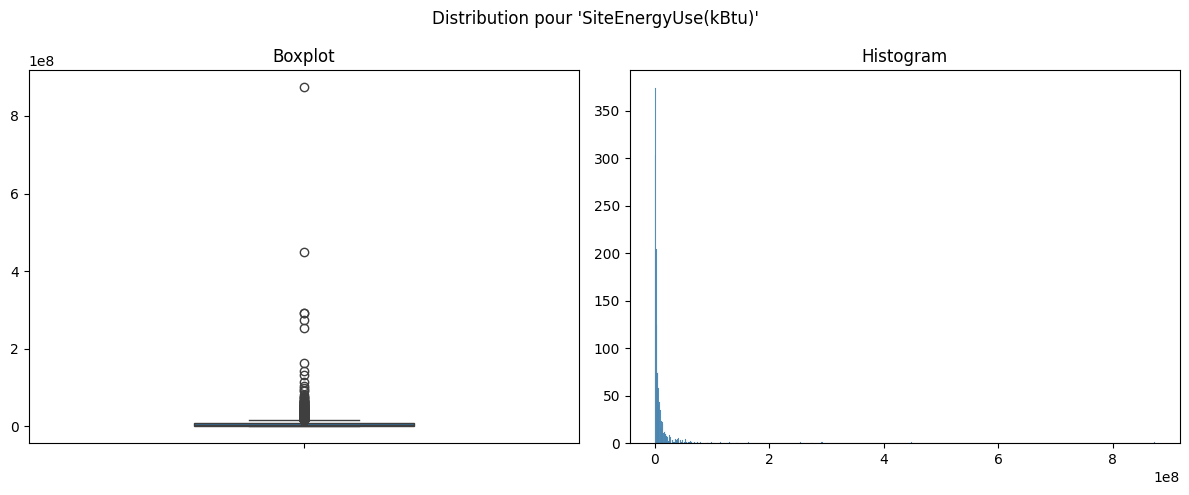

In [26]:
plot_histbox(data, 'SiteEnergyUse(kBtu)')

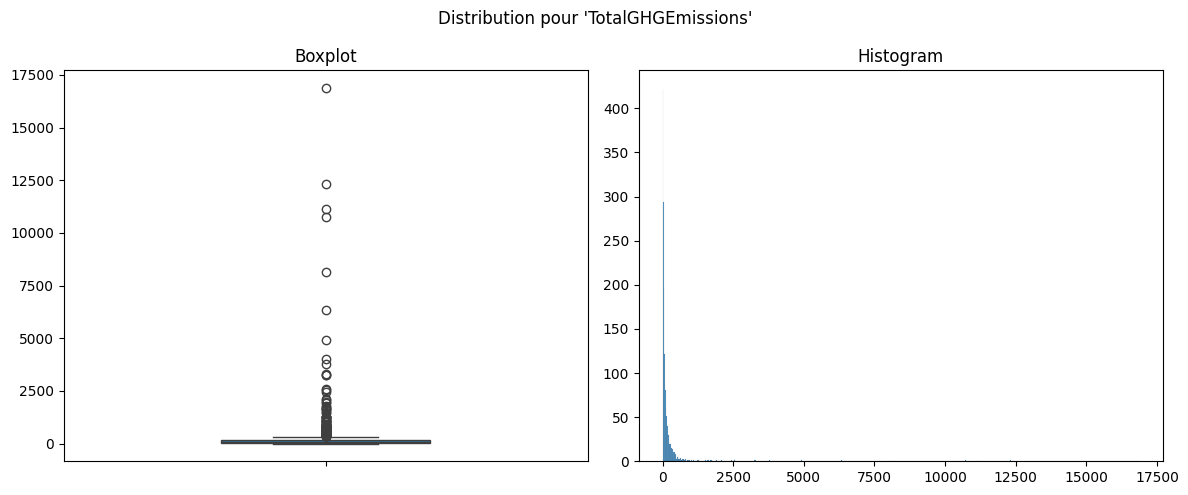

In [27]:
plot_histbox(data, 'TotalGHGEmissions')

## Feature engineering

In [28]:
data['elec_coef'] = data['Electricity(kBtu)']/data['SiteEnergyUse(kBtu)']
data['steam_coef'] = data['SteamUse(kBtu)']/data['SiteEnergyUse(kBtu)']
data['gas_coef'] = data['NaturalGas(kBtu)']/data['SiteEnergyUse(kBtu)']

In [29]:
data['use_gas'] = (data['gas_coef'] > 0).astype(int)
data['use_steam'] = (data['steam_coef'] > 0).astype(int)
data['elec_main'] = (data['elec_coef'] >= 0.8).astype(int)

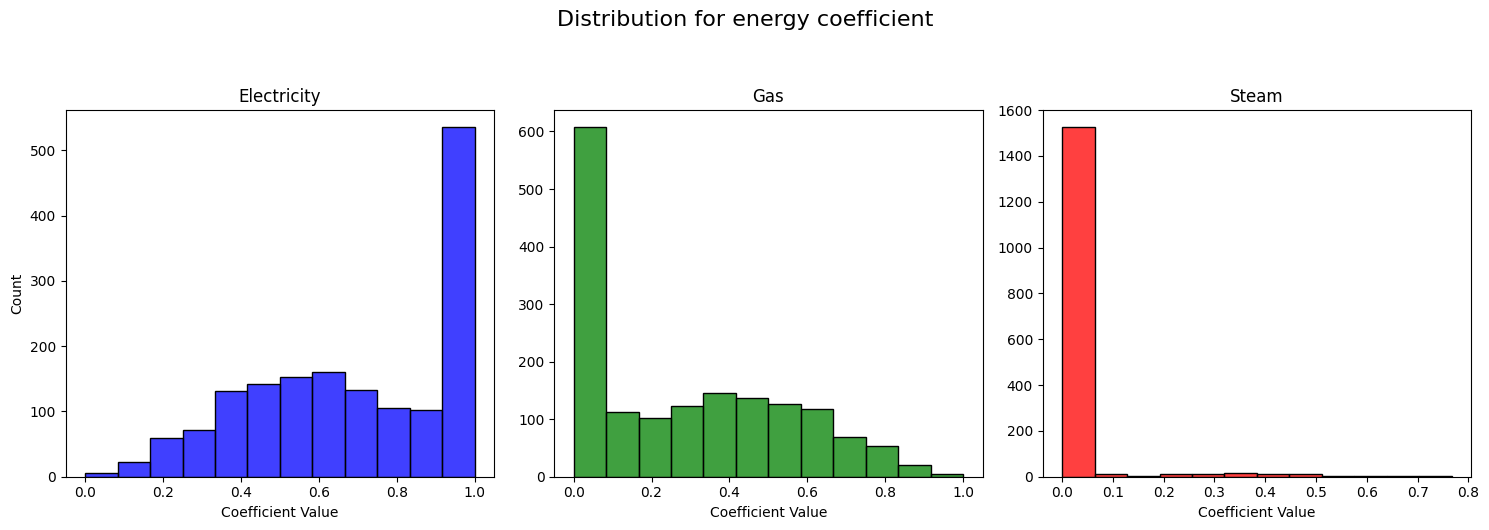

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Distribution for energy coefficient", fontsize=16, y=1.05)

# Electricity coefficient distribution
sns.histplot(data['elec_coef'], ax=ax[0], color="blue")
ax[0].set_title("Electricity")
ax[0].set_xlabel("Coefficient Value")
ax[0].set_ylabel("Count")

# Gas coefficient distribution
sns.histplot(data['gas_coef'], ax=ax[1], color="green")
ax[1].set_title("Gas")
ax[1].set_xlabel("Coefficient Value")
ax[1].set_ylabel("")

# Steam coefficient distribution
sns.histplot(data['steam_coef'], ax=ax[2], color="red")
ax[2].set_title("Steam")
ax[2].set_xlabel("Coefficient Value")
ax[2].set_ylabel("")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [31]:
list_del = ['Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)']

data = data.drop(columns=list_del)

del list_del

### Nettoyage colonnes energies (elec/gas/steam)

In [32]:
# Suppression du reste des colonnes energétiques qui ne seront pas target

list_del = ['SiteEUI(kBtu/sf)',
            'SiteEUIWN(kBtu/sf)',
            'SourceEUI(kBtu/sf)',
            'SourceEUIWN(kBtu/sf)',
            'SiteEnergyUseWN(kBtu)',
            'Electricity(kWh)',
            'NaturalGas(therms)',
            'GHGEmissionsIntensity']

data = data.drop(columns=list_del)

del list_del

### Transfo yearbuilt -> age

In [33]:
# Transformation de YearBuilt en nombre d'années depuis la construction

data['age_batiment'] = 2016 - data['YearBuilt']

data = data.drop(columns='YearBuilt')

### Feature engineering nb bat et floor

In [34]:
np.sort(data['NumberofBuildings'].unique())

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  14.,  23.,  27., 111.])

In [35]:
np.sort(data['NumberofFloors'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 33, 34, 36, 37,
       39, 41, 42, 46, 47, 49, 55, 56, 63, 76, 99], dtype=int64)

In [36]:
# Remplacement des 0 pour NumberofBuildings and NumberofFloors

for col in ['NumberofFloors', 'NumberofBuildings']:
    
    data.loc[data[col] == 0, col] = 1

In [37]:
data["has_multiple_buildings"] = (data['NumberofBuildings'] > 1).astype(int)

data["has_multiple_floors"] = (data['NumberofFloors'] > 1).astype(int)

### Feature has_multiple_usage

In [38]:
data['has_two_usage'] = (~data['SecondLargestPropertyUseType'].isnull()).astype(int)

data['has_three_usage'] = (~data['ThirdLargestPropertyUseType'].isnull()).astype(int)

In [39]:
data['nb_uses'] = data['ListOfAllPropertyUseTypes'].apply(lambda x: len(x.split(',')))

### Feature distance_from_citycenter

In [40]:
citycenter_coordinates = (47.620564, -122.350616)

data['distance_to_center'] = data.apply(
    lambda row: geodesic((row['Latitude'], row['Longitude']), citycenter_coordinates).km,
    axis=1
)

### Mise en forme de la colonne 'Neighborhood'

In [41]:
# Correction et standardisation des quartiers

data.loc[:, 'Neighborhood'] = data.loc[:, 'Neighborhood'].str.lower()

data.loc[data['Neighborhood'] == 'delridge neighborhoods', 'Neighborhood'] = 'delridge'

In [42]:
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Address', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'ComplianceStatus', 'TotalGHGEmissions',
       'elec_coef', 'steam_coef', 'gas_coef', 'use_gas', 'use_steam',
       'elec_main', 'age_batiment', 'has_multiple_buildings',
       'has_multiple_floors', 'has_two_usage', 'has_three_usage', 'nb_uses',
       'distance_to_center'],
      dtype='object')

### Etude des relations avec variable cible

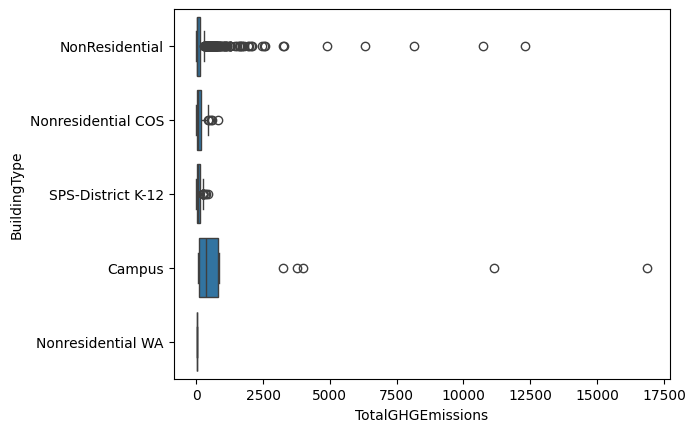

In [43]:
sns.boxplot(data, y='BuildingType', x='TotalGHGEmissions');

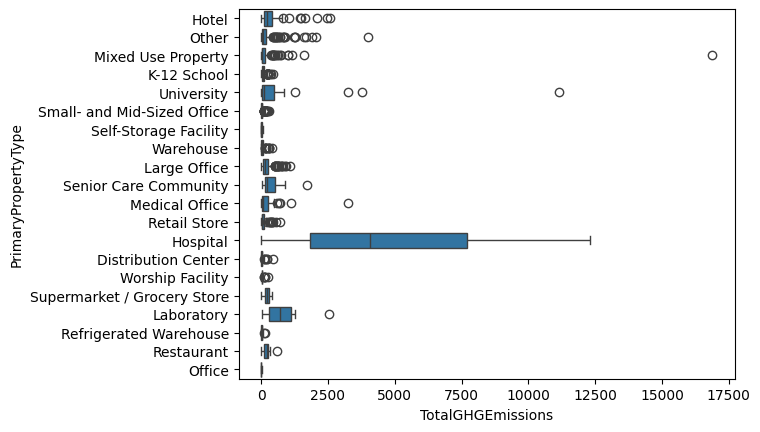

In [44]:
sns.boxplot(data, y='PrimaryPropertyType', x='TotalGHGEmissions');

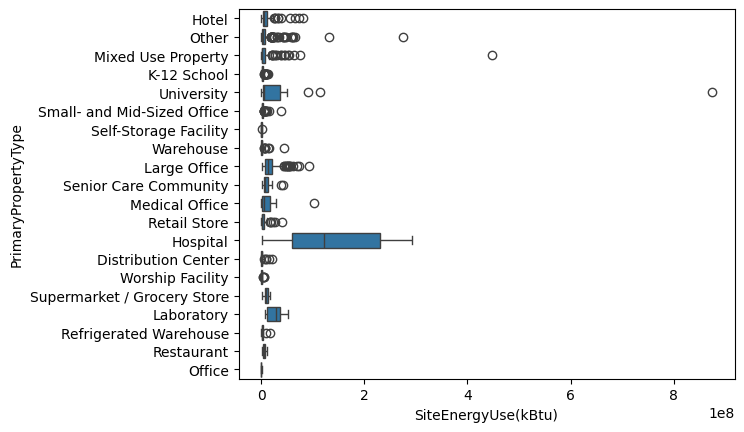

In [45]:
sns.boxplot(data, y='PrimaryPropertyType', x='SiteEnergyUse(kBtu)');

### Zone à haute emissions

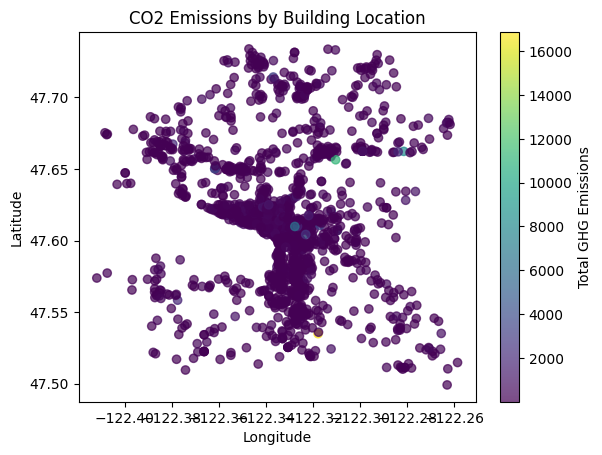

In [46]:
plt.scatter(data['Longitude'], data['Latitude'], c=data['TotalGHGEmissions'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Total GHG Emissions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('CO2 Emissions by Building Location')
plt.show()

### Traitement des outliers

In [47]:
def plot_target_outlier():
    fig, ax = plt.subplots(2, 2, figsize=(12, 6))

    # Boxplots
    sns.boxplot(x=data['TotalGHGEmissions'], ax=ax[0, 0], color="blue")
    sns.boxplot(x=data['SiteEnergyUse(kBtu)'], ax=ax[0, 1], color="green")

    # Histograms
    sns.histplot(data['TotalGHGEmissions'], kde=True, bins=30, ax=ax[1, 0], color="blue", label="Energy Consumption")
    sns.histplot(data['SiteEnergyUse(kBtu)'], kde=True, bins=30, ax=ax[1, 1], color="green", label="CO2 Emissions")

    # Titles and Labels
    ax[0, 0].set_title('Boxplot of Energy Consumption')
    ax[0, 1].set_title('Boxplot of CO2 Emissions')
    ax[1, 0].set_title('Histogram of Energy Consumption')
    ax[1, 1].set_title('Histogram of CO2 Emissions')

    ax[1, 0].set_xlabel('Energy Consumption')
    ax[1, 1].set_xlabel('CO2 Emissions')

    plt.tight_layout()
    plt.show()

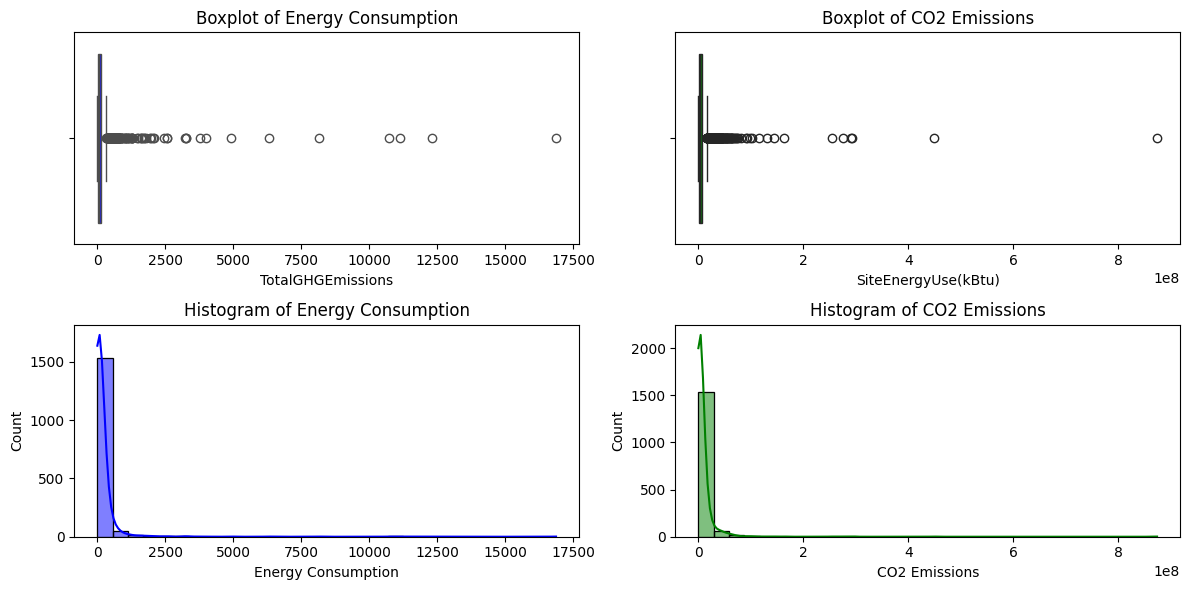

In [48]:
plot_target_outlier()

In [49]:
pd.set_option('display.float_format', '{:,.2f}'.format)
display(data[['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']].describe().round(2))
pd.reset_option('display.float_format')

,SiteEnergyUse(kBtu),TotalGHGEmissions
count,"1,620.00","1,620.00"
mean,"8,608,739.09",188.23
std,"30,647,988.57",762.18
min,"16,808.90",0.12
25%,"1,253,390.09",20.32
50%,"2,588,369.00",49.74
75%,"7,103,784.25",144.50
max,"873,923,712.00","16,870.98"


## Traitement des outliers avec IQR

limite_energie = limite_haute(data['SiteEnergyUse(kBtu)'])
limite_co2 = limite_haute(data['TotalGHGEmissions'])
limite_gfabuildings = limite_haute(data['PropertyGFABuilding(s)'])

list_outliers = set()

list_outliers.update(data[data['SiteEnergyUse(kBtu)'] > limite_energie].index)

list_outliers.update(data[data['TotalGHGEmissions'] > limite_co2].index)

list_outliers.update(data[data['PropertyGFABuilding(s)'] > limite_gfabuildings].index)

data_outlier = data.loc[data.index.isin(list_outliers),:]

data = data.loc[~data.index.isin(list_outliers),:]

In [50]:
### Traitement des outliers avec Z score

treshold = 3

scaler = StandardScaler()

data['z_energie'] = scaler.fit_transform(data[['SiteEnergyUse(kBtu)']])
data['z_co2'] = scaler.fit_transform(data[['TotalGHGEmissions']])
data['z_building'] = scaler.fit_transform(data[['PropertyGFABuilding(s)']])

print(data.shape)

data = data[
    (np.abs(data['z_energie']) < treshold) &
    (np.abs(data['z_co2']) < treshold) &
    (np.abs(data['z_building']) < treshold)
]

print(data.shape)


(1620, 40)
(1593, 40)


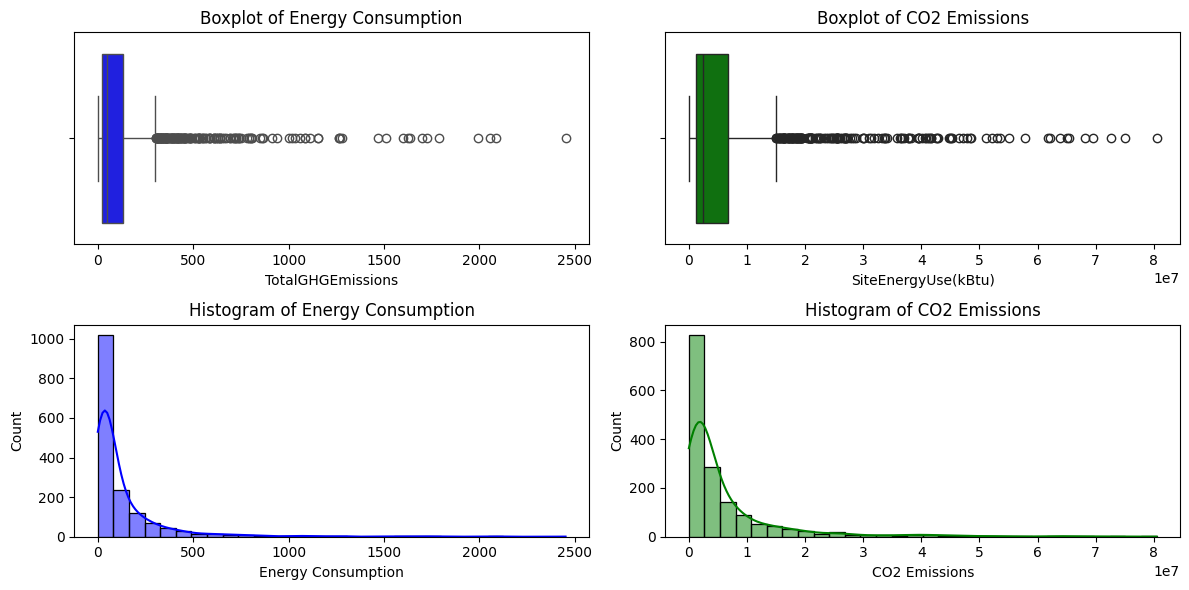

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))

# Boxplots
sns.boxplot(x=data['TotalGHGEmissions'], ax=ax[0, 0], color="blue")
sns.boxplot(x=data['SiteEnergyUse(kBtu)'], ax=ax[0, 1], color="green")

# Histograms
sns.histplot(data['TotalGHGEmissions'], kde=True, bins=30, ax=ax[1, 0], color="blue", label="Energy Consumption")
sns.histplot(data['SiteEnergyUse(kBtu)'], kde=True, bins=30, ax=ax[1, 1], color="green", label="CO2 Emissions")

ax[0, 0].set_title('Boxplot of Energy Consumption')
ax[0, 1].set_title('Boxplot of CO2 Emissions')
ax[1, 0].set_title('Histogram of Energy Consumption')
ax[1, 1].set_title('Histogram of CO2 Emissions')

ax[1, 0].set_xlabel('Energy Consumption')
ax[1, 1].set_xlabel('CO2 Emissions')

plt.tight_layout()
plt.show()

In [52]:
data.shape

(1593, 40)

In [53]:
data.head()

,BuildingType,PrimaryPropertyType,Address,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),ComplianceStatus,TotalGHGEmissions,elec_coef,steam_coef,gas_coef,use_gas,use_steam,elec_main,age_batiment,has_multiple_buildings,has_multiple_floors,has_two_usage,has_three_usage,nb_uses,distance_to_center,z_energie,z_co2,z_building
0,NonResidential,Hotel,405 Olive way,98101.0,7,downtown,47.61220,-122.33799,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,0.0,NaN,0.0,60.0,7226362.5,Compliant,249.98,0.546060,0.277302,0.176638,1,1,0,89,0,1,0,0,1,1.328806,-0.045119,0.081042,-0.062266
1,NonResidential,Hotel,724 Pine street,98101.0,7,downtown,47.61317,-122.33393,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,8387933.0,Compliant,295.86,0.386609,0.000000,0.613391,1,0,0,20,0,1,1,1,3,1.499773,-0.007207,0.141257,-0.062029
2,NonResidential,Hotel,1900 5th Avenue,98101.0,7,downtown,47.61393,-122.33810,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,0.0,NaN,0.0,43.0,72587024.0,Compliant,2089.28,0.682307,0.297113,0.020579,1,1,0,47,0,1,0,0,1,1.195544,2.088164,2.495010,2.281072
3,NonResidential,Hotel,620 STEWART ST,98101.0,7,downtown,47.61412,-122.33664,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,0.0,NaN,0.0,56.0,6794584.0,Compliant,286.43,0.407519,0.325913,0.266567,1,1,0,90,0,1,0,0,1,1.271688,-0.059212,0.128881,-0.156963
4,NonResidential,Hotel,401 LENORA ST,98121.0,7,downtown,47.61375,-122.34047,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,14172606.0,Compliant,505.01,0.378802,0.000000,0.621198,1,0,0,36,0,1,1,1,3,1.075044,0.181597,0.415753,0.025557


In [54]:
# Changement du building type Nonresidential WA

data.loc[data['BuildingType'] == 'Nonresidential WA', 'BuildingType'] = 'NonResidential'


data['BuildingType'].value_counts()

BuildingType
NonResidential        1407
Nonresidential COS      84
SPS-District K-12       84
Campus                  18
Name: count, dtype: int64

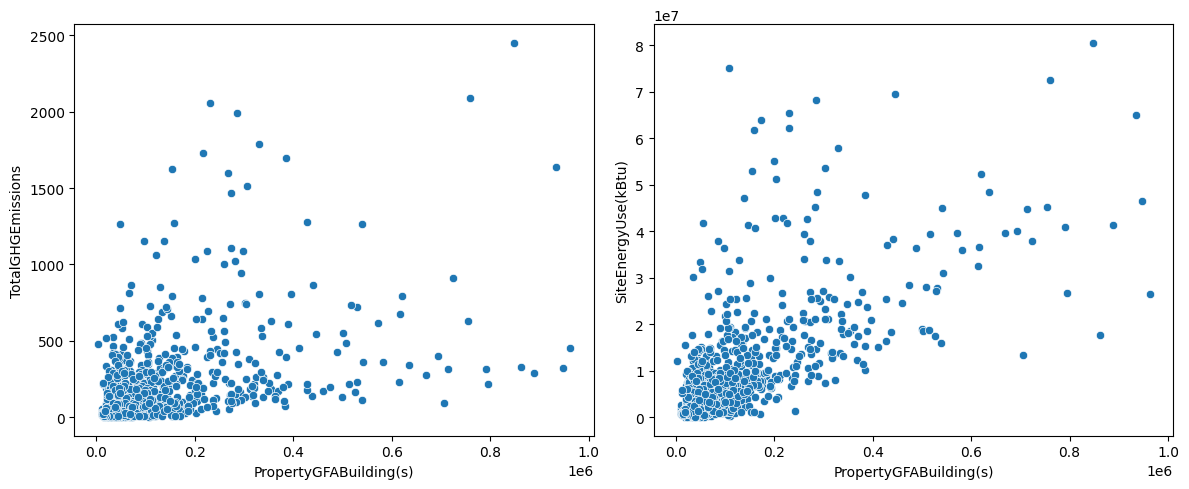

In [55]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(data, x='PropertyGFABuilding(s)', y='TotalGHGEmissions', ax=ax[0])
sns.scatterplot(data, x='PropertyGFABuilding(s)', y='SiteEnergyUse(kBtu)', ax=ax[1])

plt.tight_layout()
plt.show();

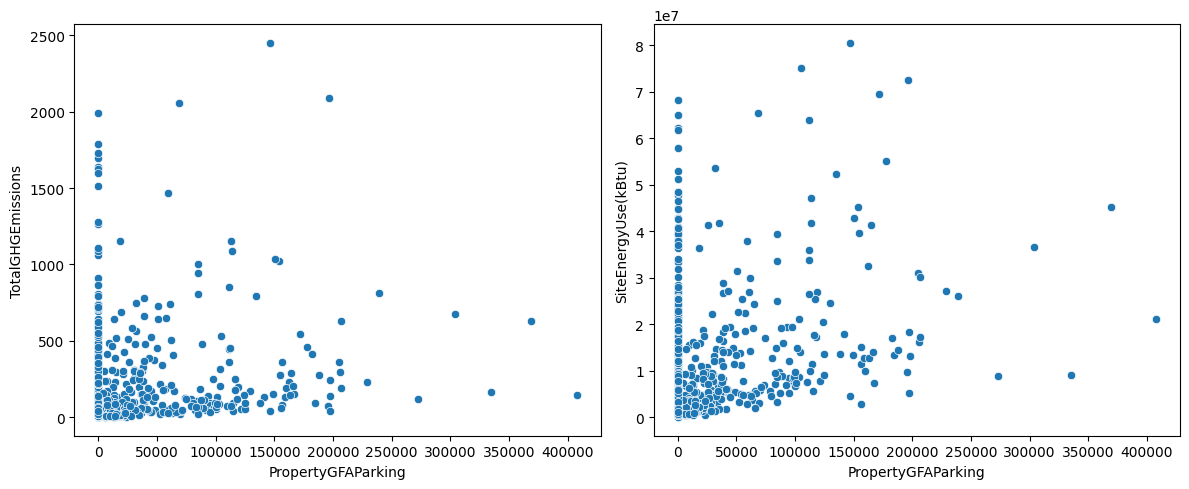

In [56]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(data, x='PropertyGFAParking', y='TotalGHGEmissions', ax=ax[0])
sns.scatterplot(data, x='PropertyGFAParking', y='SiteEnergyUse(kBtu)', ax=ax[1])

plt.tight_layout()
plt.show();

In [57]:
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Address', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'ComplianceStatus', 'TotalGHGEmissions',
       'elec_coef', 'steam_coef', 'gas_coef', 'use_gas', 'use_steam',
       'elec_main', 'age_batiment', 'has_multiple_buildings',
       'has_multiple_floors', 'has_two_usage', 'has_three_usage', 'nb_uses',
       'distance_to_center', 'z_energie', 'z_co2', 'z_building'],
      dtype='object')

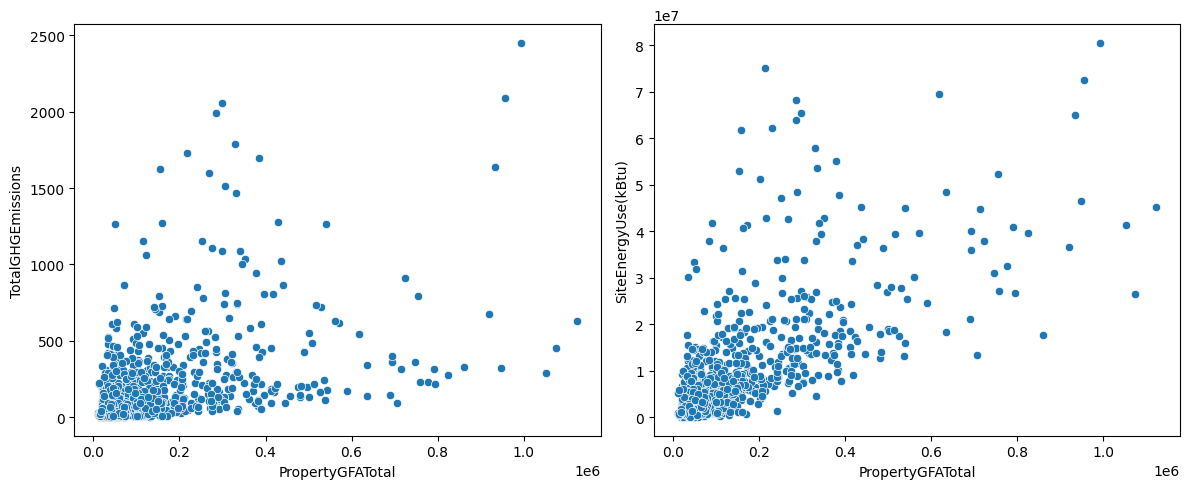

In [58]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(data, x='PropertyGFATotal', y='TotalGHGEmissions', ax=ax[0])
sns.scatterplot(data, x='PropertyGFATotal', y='SiteEnergyUse(kBtu)', ax=ax[1])

plt.tight_layout()
plt.show();

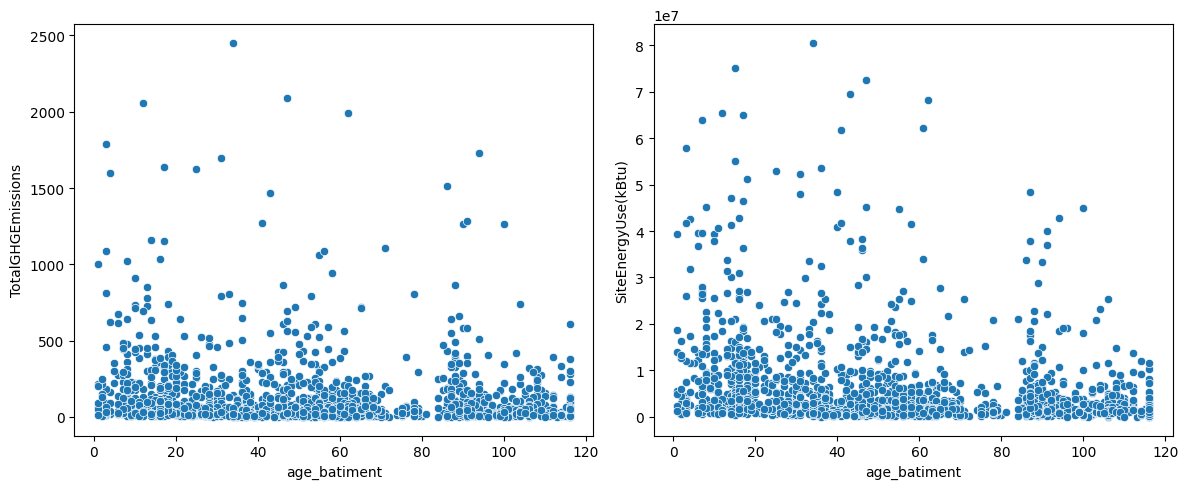

In [59]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(data, x='age_batiment', y='TotalGHGEmissions', ax=ax[0])
sns.scatterplot(data, x='age_batiment', y='SiteEnergyUse(kBtu)', ax=ax[1])

plt.tight_layout()
plt.show();

### Feature cluster Kmean lat/long

In [60]:
from sklearn.metrics import silhouette_score

In [61]:
X = data[['Latitude', 'Longitude']].to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

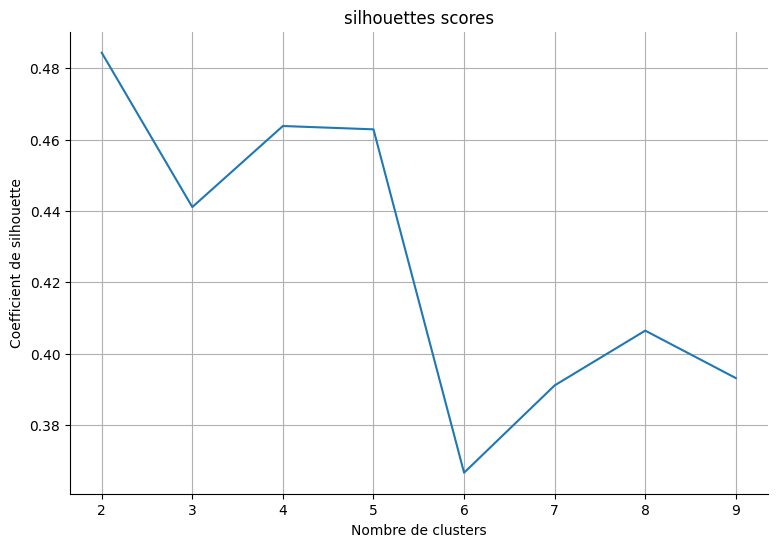

In [62]:
K_range = range(2, 10)
silhouette_scores = []

for n_clusters in K_range:
    km = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    km_labels = km.predict(X)
    si_coef = silhouette_score(X, km_labels)   
    silhouette_scores.append(si_coef)
    
fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(1,1,1)
plt.plot(K_range, silhouette_scores)
ax.set_title('silhouettes scores')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Coefficient de silhouette')
plt.grid()
plt.show()

In [63]:
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(data[['Latitude', 'Longitude']])

kmeans = KMeans(n_clusters=5, random_state=42)
data['spacial_cluster'] = (kmeans.fit_predict(coords_scaled) + 1).astype(str)

In [64]:
data['spacial_cluster'].value_counts()

spacial_cluster
4    691
2    284
3    258
1    246
5    114
Name: count, dtype: int64

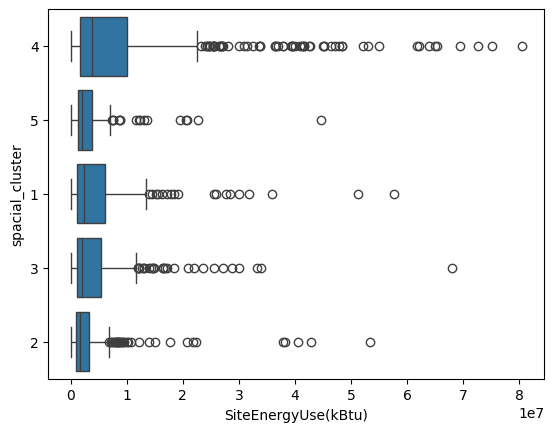

In [65]:
sns.boxplot(data, x='SiteEnergyUse(kBtu)', y='spacial_cluster');

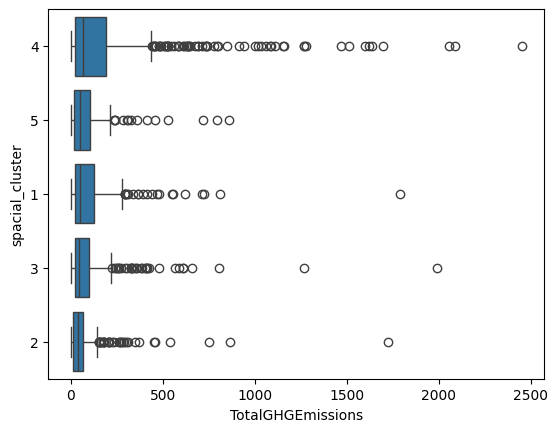

In [66]:
sns.boxplot(data, x='TotalGHGEmissions', y='spacial_cluster');

# Modele

In [67]:
# Replacing null values with mean for ENERGYSTARScore

data.loc[data['ENERGYSTARScore'].isnull(), 'ENERGYSTARScore'] = data['ENERGYSTARScore'].mean()

In [68]:
### Combining neihgborhood and district code

data['CouncilDistrictCode'] = data['CouncilDistrictCode'].astype(str)

data['neighdistrict'] = data['Neighborhood'] + '_' + data['CouncilDistrictCode']

### Grouping Primarypropertytype

data.loc[data['PrimaryPropertyType'] == 'Small- and Mid-Sized Office', 'PrimaryPropertyType'] = 'Office'
data.loc[data['PrimaryPropertyType'].isin(['Supermarket / Grocery Store', 'Restaurant']), 'PrimaryPropertyType'] = 'Retail Store'
data.loc[data['PrimaryPropertyType'].isin(['Hospital','Laboratory']), 'PrimaryPropertyType'] = 'Medical'
data.loc[data['PrimaryPropertyType'].isin(['Self-Storage Facility', 'Warehouse', 'Worship Facility', 'Distribution Center']), 'PrimaryPropertyType'] = 'Other'

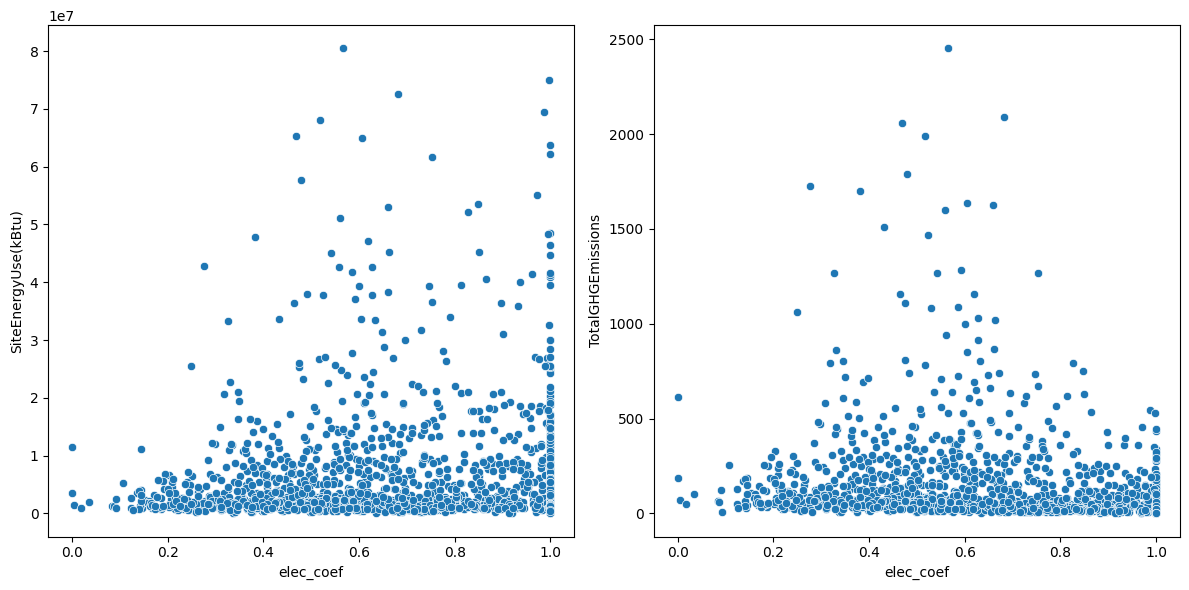

In [69]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

sns.scatterplot(data, x='elec_coef', y='SiteEnergyUse(kBtu)', ax=ax[0])
sns.scatterplot(data, x='elec_coef', y='TotalGHGEmissions', ax=ax[1])

plt.tight_layout()
plt.show()

### Encoding

In [70]:
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Address', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'ComplianceStatus', 'TotalGHGEmissions',
       'elec_coef', 'steam_coef', 'gas_coef', 'use_gas', 'use_steam',
       'elec_main', 'age_batiment', 'has_multiple_buildings',
       'has_multiple_floors', 'has_two_usage', 'has_three_usage', 'nb_uses',
       'distance_to_center', 'z_energie', 'z_co2', 'z_building',
       'spacial_cluster', 'neighdistrict'],
      dtype='object')

In [71]:
features = [
    'nb_uses',
    'Latitude',
    'Longitude',
    'BuildingType',
    #'neighdistrict',
    #'CouncilDistrictCode',
    'LargestPropertyUseType',
    #'LargestPropertyUseTypeGFA',
    #'SecondLargestPropertyUseTypeGFA',
    #'ThirdLargestPropertyUseTypeGFA',
    #'Neighborhood',
    #'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'elec_coef',
    'steam_coef',
    #'gas_coef',
    'age_batiment',
    #'has_multiple_floors',
    #'has_multiple_buildings',
    'NumberofBuildings',
    'NumberofFloors',
    'PrimaryPropertyType',
    'ENERGYSTARScore',
    #'has_two_usage',
    #'has_three_usage',
    'distance_to_center',
    #'use_gas',
    #'use_steam',
    #'elec_main',
    #'spacial_cluster'
            ]

column_to_encode = [
    #'neighdistrict',
    #'CouncilDistrictCode',
    'LargestPropertyUseType',
    #'Neighborhood',
    'BuildingType',
    'PrimaryPropertyType',
    #'spacial_cluster'
    ]

columns_to_scale = [
    'nb_uses',
    'Latitude',
    'Longitude',
    'elec_coef',
    'steam_coef',
    'NumberofBuildings',
    'NumberofFloors',
    #'gas_coef',
    #'PropertyGFATotal',
    'PropertyGFAParking', 
    'PropertyGFABuilding(s)',
    #'LargestPropertyUseTypeGFA',
    #'SecondLargestPropertyUseTypeGFA',
    #'ThirdLargestPropertyUseTypeGFA',    
    'age_batiment',
    'ENERGYSTARScore',
    'distance_to_center'
    ]

In [72]:
X = data.loc[:, features]

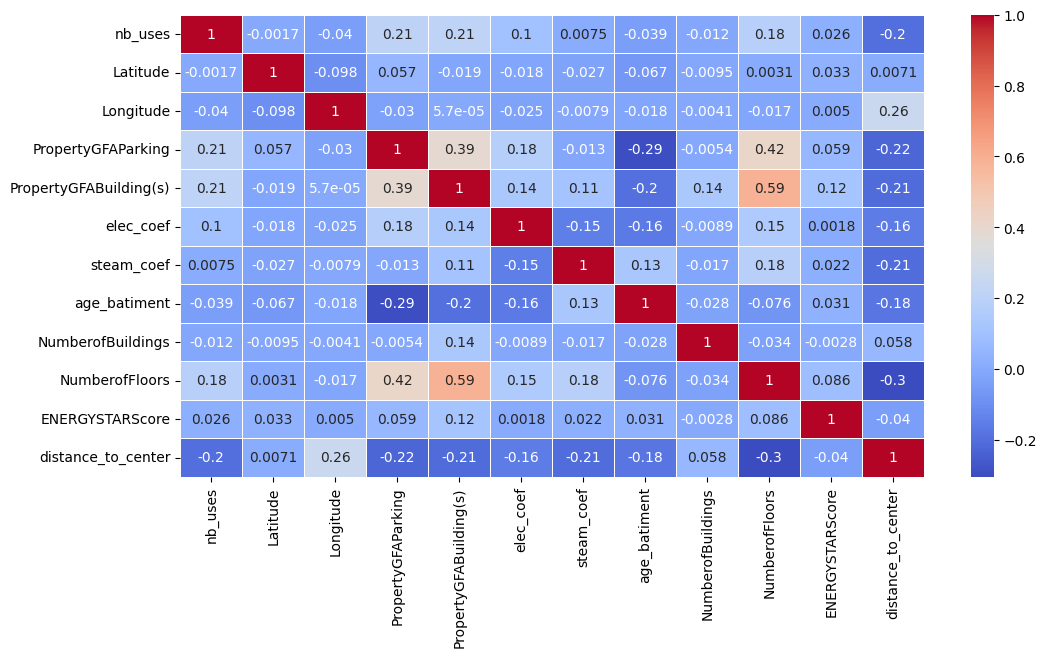

In [73]:
corr_table = X.corr(numeric_only=True)
plt.figure(figsize=(12, 6))
sns.heatmap(corr_table, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show();

In [74]:
categorical_columns = X.select_dtypes(['category','object']).columns
numerical_columns = X.select_dtypes(['int32','float64']).columns

In [75]:
#y1 = np.log1p(data.loc[:, 'SiteEnergyUse(kBtu)'])
y1 = data.loc[:, 'SiteEnergyUse(kBtu)']

#y2 = np.log1p(data.loc[:, 'TotalGHGEmissions'])
y2 = data.loc[:, 'TotalGHGEmissions']

In [76]:
#y1.to_csv('y1_energie.csv', index=False)

#y2.to_csv('y2_co2.csv', index=False)

In [77]:
X = pd.get_dummies(X, columns=column_to_encode, dtype=int)

In [78]:
#scaler = StandardScaler()
scaler = MinMaxScaler()

In [79]:
X[columns_to_scale] = X[columns_to_scale].astype(float)
X.loc[:, columns_to_scale] = scaler.fit_transform(X.loc[:, columns_to_scale])

In [80]:
#X.to_csv('data_clean.csv', index=False)

### First models try

In [81]:
import re

In [82]:
X.columns = [re.sub(r'[^0-9A-Za-z_]', '_', col) for col in X.columns]

In [83]:
models = [
    DummyRegressor(),
    LinearRegression(),
    Ridge(),
    Lasso(),
    KNeighborsRegressor(n_neighbors=5),
    SVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    lgb.LGBMRegressor(verbose=-1),
    GradientBoostingRegressor(),
    ExtraTreesRegressor(),
    xgb.XGBRegressor(),
    CatBoostRegressor(verbose=0)
]

In [84]:
def regression(model, name, X, y):
    metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
    score = cross_validate(model, X, y , cv=5, scoring=metrics, return_train_score=True)
    
    dic = {
        'model': [name],
        'train_r2': [score['train_r2'].mean()],
        'test_r2': [score['test_r2'].mean()],
        'train_RMSE': [np.sqrt(- (score['train_neg_mean_squared_error'].mean()))],
        'test_RMSE': [np.sqrt(- (score['test_neg_mean_squared_error'].mean()))],
        'train_MAE': [np.sqrt(- (score['train_neg_mean_absolute_error'].mean()))],
        'test_MAE': [np.sqrt(- (score['test_neg_mean_absolute_error'].mean()))],
        'training_time': [score['fit_time'].mean()]
    }
    return pd.DataFrame(dic)


ordered_cols = ['model', 'train_r2', 'test_r2', 'train_RMSE', 'test_RMSE', 'train_MAE', 'test_MAE', 'training_time']

def compare_results(X, y, models):
    model_names = [m.__class__.__name__ for m in models]
    results = pd.DataFrame()   
    for name, model in zip(model_names, models):
        res = regression(model, name, X, y)
        results = pd.concat([results, res], ignore_index=True)
    return results[ordered_cols]

In [85]:
results_y1 = compare_results(X, y1, models)

c:\Applications\01_data_engineer\06_batiment_consommation\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.050e+15, tolerance: 5.937e+12
  model = cd_fast.enet_coordinate_descent(
c:\Applications\01_data_engineer\06_batiment_consommation\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.241e+16, tolerance: 1.249e+13
  model = cd_fast.enet_coordinate_descent(
c:\Applications\01_data_engineer\06_batiment_consommation\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number o

In [86]:
results_y2 = compare_results(X, y2, models)

In [87]:
results_y1.sort_values(by='test_RMSE')

,model,train_r2,test_r2,train_RMSE,test_RMSE,train_MAE,test_MAE,training_time
11,ExtraTreesRegressor,1.000000,0.607265,1.506744e-10,5.852253e+06,0.000005,1606.051561,0.780212
10,GradientBoostingRegressor,0.902568,0.538717,3.000742e+06,5.978228e+06,1296.543148,1658.045268,0.327262
1,LinearRegression,0.696805,0.386380,5.282680e+06,6.045956e+06,1646.174015,1771.253780,0.073859
3,Lasso,0.696805,0.383314,5.282680e+06,6.057806e+06,1646.176298,1775.825761,0.056816
2,Ridge,0.688700,0.426715,5.346513e+06,6.090220e+06,1655.052345,1765.482827,0.003399
7,RandomForestRegressor,0.949863,0.558491,2.132407e+06,6.118718e+06,967.725259,1653.133746,1.196731
13,CatBoostRegressor,0.976829,0.554099,1.467767e+06,6.147474e+06,975.480900,1646.322499,1.609680
12,XGBRegressor,0.997273,0.500404,4.838015e+05,6.421284e+06,581.187448,1715.001299,0.150958
9,LGBMRegressor,0.926573,0.450903,2.576380e+06,6.693820e+06,1117.771275,1780.862364,0.047787
6,DecisionTreeRegressor,1.000000,0.288238,-0.000000e+00,7.358728e+06,-0.000000,1865.545011,0.019997


In [88]:
results_y2.sort_values(by='test_RMSE')

,model,train_r2,test_r2,train_RMSE,test_RMSE,train_MAE,test_MAE,training_time
13,CatBoostRegressor,0.981443,0.603874,3.043688e+01,139.411040,4.468561e+00,7.613796,1.890011
10,GradientBoostingRegressor,0.909263,0.582103,6.792149e+01,141.178438,6.222921e+00,7.977743,0.327086
11,ExtraTreesRegressor,1.000000,0.589056,3.732768e-13,146.133861,3.953964e-07,7.649096,0.797647
7,RandomForestRegressor,0.951762,0.524675,4.918118e+01,148.973971,4.654701e+00,7.887672,1.037958
9,LGBMRegressor,0.925769,0.518543,6.017645e+01,150.169617,5.305399e+00,8.277691,0.048601
12,XGBRegressor,0.998159,0.506687,9.468332e+00,150.619827,2.550910e+00,8.061865,0.160195
2,Ridge,0.604313,0.367362,1.416674e+02,162.662293,8.661594e+00,9.201127,0.003177
1,LinearRegression,0.610438,0.341076,1.406227e+02,162.820326,8.639650e+00,9.271037,0.009762
3,Lasso,0.551016,0.380985,1.503980e+02,167.448423,8.761014e+00,9.125078,0.004179
6,DecisionTreeRegressor,1.000000,0.235921,-0.000000e+00,185.514372,-0.000000e+00,9.128885,0.017702


### Extra Tree Regressor

In [89]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

etr = ExtraTreesRegressor(random_state=42, n_jobs=-1)

GS = GridSearchCV(
    estimator=etr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',  
    verbose=2,
    n_jobs=-1
)

#X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42)

#random_search.fit(X_train, y_train)

GS.fit(X, y1)

print("Best parameters:", GS.best_params_)
print("Best cross-validation RMSE:", GS.best_score_)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits
Best parameters: {'max_depth': 40, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation RMSE: -4976771.927436721


In [90]:
etr = ExtraTreesRegressor(random_state=42, n_jobs=-1, **GS.best_params_)

cv_results = cross_validate(
    etr, X, y1,
    cv=5,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
    return_train_score=True
)

cv_results = pd.DataFrame(cv_results) 

In [91]:
cv_results

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2
0,0.134000,0.031002,-5.406299e+06,-8.010719e+05,-1.070198e+14,-3.355842e+12,0.517135,0.927994
1,0.140274,0.032999,-3.032927e+06,-9.986113e+05,-2.826386e+13,-6.128396e+12,0.636037,0.937482
2,0.125548,0.033000,-1.224954e+06,-1.170806e+06,-6.338935e+12,-7.037262e+12,0.584011,0.936406
3,0.138998,0.031999,-1.024561e+06,-1.195123e+06,-3.435832e+12,-7.641060e+12,0.731268,0.930781
4,0.121629,0.034000,-2.239888e+06,-1.045266e+06,-2.353337e+13,-6.240902e+12,0.622803,0.938762


In [92]:
importances = GS.best_estimator_.feature_importances_

df_feat = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(importances)
})

In [93]:
df_feat.nlargest(10, 'Importance')

,Feature,Importance
4,PropertyGFABuilding_s_,0.524090
10,ENERGYSTARScore,0.054105
9,NumberofFloors,0.048600
3,PropertyGFAParking,0.042801
78,PrimaryPropertyType_Mixed_Use_Property,0.034320
76,PrimaryPropertyType_Large_Office,0.027613
64,LargestPropertyUseType_Urgent_Care_Clinic_Othe...,0.019350
72,PrimaryPropertyType_Hospital,0.016207
17,LargestPropertyUseType_Data_Center,0.015869
23,LargestPropertyUseType_Hospital__General_Medic...,0.015134


### CatBoost

In [94]:
param_grid_cat = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7]
}

cat_model = CatBoostRegressor(random_seed=42, verbose=0)

cat_GS = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid_cat,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

cat_GS.fit(X, y2)

print("Best parameters for CatBoost:", cat_GS.best_params_)
print("Best cross-validation RMSE for CatBoost:", cat_GS.best_estimator_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for CatBoost: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best cross-validation RMSE for CatBoost: <catboost.core.CatBoostRegressor object at 0x00000281821FA1F0>


In [95]:
cat = CatBoostRegressor(random_state=42, verbose=0, **cat_GS.best_params_)

cv_results = cross_validate(
    cat, X, y2,
    cv=5,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],
    return_train_score=True
)

cv_results = pd.DataFrame(cv_results) 

In [96]:
cv_results

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2
0,1.733116,0.005001,-117.065316,-3.920886,-60625.503887,-25.946819,0.516304,0.999021
1,1.747552,0.006001,-59.418234,-4.596489,-13625.266494,-35.649708,0.608305,0.999360
2,1.736805,0.006001,-36.126974,-4.956901,-6034.491795,-41.223375,0.550242,0.999312
3,1.689013,0.005000,-29.759224,-5.184919,-4156.346902,-44.777121,0.640674,0.999254
4,1.609648,0.006000,-53.290152,-4.707774,-10376.954253,-37.054837,0.757964,0.999308


In [97]:
importance = cat_GS.best_estimator_.feature_importances_

df_feat_y2 = pd.DataFrame({
    'Feature' : X.columns,
    'Importance' : np.abs(importance)
})

In [98]:
df_feat_y2.nlargest(10, 'Importance')

,Feature,Importance
4,PropertyGFABuilding_s_,33.935084
5,elec_coef,24.474438
10,ENERGYSTARScore,5.759193
9,NumberofFloors,4.657124
3,PropertyGFAParking,3.821569
7,age_batiment,3.466962
6,steam_coef,3.109929
2,Longitude,2.369536
11,distance_to_center,2.230101
1,Latitude,2.086428


In [115]:
energy_model = etr
co2_model = cat

In [113]:
import bentoml

In [ ]:
saved_energy_model = bentoml.sklearn.save_model("energy_model", energy_model)
print("Energy model saved as:", energy_model)

saved_co2_model = bentoml.catboost.save_model("co2_model", co2_model)
print("CO2 model saved as:", co2_model)

ImportError: cannot import name 'NOTHING' from 'attr' (c:\Applications\01_data_engineer\06_batiment_consommation\.venv\lib\site-packages\attr.py)